In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

def get_dataset_info(base_dir):
    splits = ['Training_images/Training_images', 'Test_images/Test_images', 'Validation_images/Validation_images']
    labels = ['Positive', 'Negative']

    info = {}
    total_samples = 0

    for split in splits:
        info[split] = {}
        split_total = 0
        for label in labels:
            dir_path = os.path.join(base_dir, split, label)
            num_samples = len(os.listdir(dir_path))
            info[split][label] = num_samples
            split_total += num_samples
        info[split]['Total'] = split_total
        total_samples += split_total

    info['Grand Total'] = total_samples
    return info

base_dir = '/content/drive/MyDrive/dataset'
info = get_dataset_info(base_dir)

for split, labels_info in info.items():
    if split != 'Grand Total':
        print(f"{split.capitalize()} Set:")
        for label, num_samples in labels_info.items():
            print(f"Number of {label} samples: {num_samples}")
    else:
        print(f"Grand total of all samples: {labels_info}")


Training_images/training_images Set:
Number of Positive samples: 2364
Number of Negative samples: 2304
Number of Total samples: 4668
Test_images/test_images Set:
Number of Positive samples: 125
Number of Negative samples: 1076
Number of Total samples: 1201
Validation_images/validation_images Set:
Number of Positive samples: 50
Number of Negative samples: 50
Number of Total samples: 100
Grand total of all samples: 5969


In [ ]:
import numpy as np
import os
import cv2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D, BatchNormalization, Activation, Dropout, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.applications import ResNet50, VGG16, VGG19, DenseNet121, DenseNet201, InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K

In [ ]:
def densenet121_model(img_rows, img_cols, color_type=3, nb_dense_block=4, growth_rate=16, nb_filter=32, reduction=0.5, dropout_rate=0.0, weight_decay=1e-4):
    '''
    DenseNet 121 Model for Keras
    Model Schema is based on https://github.com/flyyufelix/DenseNet-Keras
    # Returns
        A Keras model instance.
    '''

    # Handle Dimension Ordering for different backends
    global concat_axis
    img_input = Input(shape=(img_rows, img_cols, color_type), name='data')
    concat_axis = 3

    # From architecture for ImageNet (Table 1 in the paper)
    nb_layers = [6,12,24,16] # For DenseNet-121

    # Initial convolution
    x = Conv2D(nb_filter, 7, strides=(2, 2), name='conv1', use_bias=False)(img_input)
    x = BatchNormalization(axis=concat_axis)(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    # Add dense blocks
    for block_idx in range(nb_dense_block - 1):
        stage = block_idx + 2
        x, nb_filter = dense_block(x, stage, nb_layers[block_idx], nb_filter, growth_rate, dropout_rate=dropout_rate)
        x = transition_block(x, stage, nb_filter, reduction=reduction, dropout_rate=dropout_rate)
        nb_filter = int(nb_filter * reduction)

    final_stage = stage + 1
    x, nb_filter = dense_block(x, final_stage, nb_layers[-1], nb_filter, growth_rate, dropout_rate=dropout_rate)

    x = BatchNormalization(axis=concat_axis)(x)
    x = Activation('relu')(x)
    x = GlobalAveragePooling2D()(x)

    x = Dense(1, activation='sigmoid')(x)  # For binary classification, we use a single neuron with sigmoid activation

    model = Model(img_input, x)

    # Learning rate is changed to 0.0001
    lr_schedule = lambda epoch, lr: 0.0001
    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
def conv_block(x, stage, branch, nb_filter, dropout_rate=None):
    '''Apply BatchNorm, Relu, bottleneck 1x1 Conv2D, 3x3 Conv2D, and optional dropout'''

    # 1x1 Convolution (Bottleneck layer)
    inter_channel = nb_filter * 4
    x = BatchNormalization(axis=concat_axis)(x)
    x = Activation('relu')(x)
    x = Conv2D(inter_channel, (1, 1), use_bias=False)(x)

    if dropout_rate:
        x = Dropout(dropout_rate)(x)

    # 3x3 Convolution
    x = BatchNormalization(axis=concat_axis)(x)
    x = Activation('relu')(x)
    x = Conv2D(nb_filter, (3, 3), padding='same', use_bias=False)(x)

    if dropout_rate:
        x = Dropout(dropout_rate)(x)

    return x


In [ ]:
def transition_block(x, stage, nb_filter, reduction=0.5, dropout_rate=None):
    '''Apply BatchNorm, 1x1 Convolution, averagePooling, optional compression, dropout'''

    x = BatchNormalization(axis=concat_axis)(x)
    x = Activation('relu')(x)
    x = Conv2D(int(nb_filter * reduction), (1, 1), use_bias=False)(x)

    if dropout_rate:
        x = Dropout(dropout_rate)(x)

    x = AveragePooling2D((2, 2), strides=(2, 2))(x)
    return x

def dense_block(x, stage, nb_layers, nb_filter, growth_rate, dropout_rate=None):
    ''' Build a dense_block where the output of each conv_block is fed to subsequent ones'''

    concat_feat = x

    for i in range(nb_layers):
        branch = i + 1
        x = conv_block(concat_feat, stage, branch, growth_rate, dropout_rate)
        concat_feat = concatenate([concat_feat, x], axis=concat_axis)

    return concat_feat, nb_filter + nb_layers * growth_rate

def resnet50_model(img_rows, img_cols, color_type=3):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, color_type))

    # Freeze the layers in the base ResNet50 model
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    predictions = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
def vgg16_model(img_rows, img_cols, color_type=3):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, color_type))

    # Freeze the layers in the base VGG16 model
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    predictions = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return model


In [ ]:
def vgg19_model(img_rows, img_cols, color_type=3):
    base_model = VGG19(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, color_type))

    # Freeze the layers in the base VGG19 model
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    predictions = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return model


In [ ]:
def densenet201_model(img_rows, img_cols, color_type=3):
    base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, color_type))

    # Freeze the layers in the base DenseNet201 model
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    predictions = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
def googlenet_model(img_rows, img_cols, color_type=3):
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, color_type))

    # Freeze the layers in the base InceptionV3 model
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    predictions = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return model


In [ ]:
def load_data(train_data_folder, validation_data_folder, img_rows, img_cols, color_type=3):
    train_datagen = ImageDataGenerator(rescale=1./255)
    valid_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        train_data_folder,
        target_size=(img_rows, img_cols),
        color_mode='rgb',
        batch_size=32,
        class_mode='binary')

    validation_generator = valid_datagen.flow_from_directory(
        validation_data_folder,
        target_size=(img_rows, img_cols),
        color_mode='rgb',
        batch_size=32,
        class_mode='binary')

    return train_generator, validation_generator

In [ ]:
train_data_folder = "/content/drive/MyDrive/dataset/Training_images/Training_images"
validation_data_folder = "/content/drive/MyDrive/dataset/Validation_images/Validation_images"
img_rows, img_cols = 128, 128

train_generator, validation_generator = load_data(train_data_folder, validation_data_folder, img_rows, img_cols)


Found 4668 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [ ]:
model_resnet50 = resnet50_model(img_rows=img_rows, img_cols=img_cols)
model_densenet121 = densenet121_model(img_rows=img_rows, img_cols=img_cols)
model_vgg16 = vgg16_model(img_rows=img_rows, img_cols=img_cols)
model_vgg19 = vgg19_model(img_rows=img_rows, img_cols=img_cols)
model_densenet201 = densenet201_model(img_rows=img_rows, img_cols=img_cols)
model_googlenet = googlenet_model(img_rows=img_rows, img_cols=img_cols)

87910968/87910968 [==============================] - 1s 0us/step


In [ ]:
filepath_resnet50 = "bestmodel_resnet50.hdf5"
checkpoint_resnet50 = ModelCheckpoint(filepath_resnet50, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
history_resnet50 = model_resnet50.fit(train_generator,
                                      steps_per_epoch=len(train_generator),
                                      epochs=10,
                                      validation_data=validation_generator,
                                      validation_steps=len(validation_generator),
                                      callbacks=[checkpoint_resnet50])

Epoch 1/10
146/146 [==============================] - ETA: 0s - loss: 0.6713 - accuracy: 0.5775
Epoch 1: val_accuracy improved from -inf to 0.67000, saving model to bestmodel_resnet50.hdf5
146/146 [==============================] - 768s 5s/step - loss: 0.6713 - accuracy: 0.5775 - val_loss: 0.6293 - val_accuracy: 0.6700
Epoch 2/10
146/146 [==============================] - ETA: 0s - loss: 0.6173 - accuracy: 0.6662
Epoch 2: val_accuracy improved from 0.67000 to 0.70000, saving model to bestmodel_resnet50.hdf5
146/146 [==============================] - 359s 2s/step - loss: 0.6173 - accuracy: 0.6662 - val_loss: 0.5889 - val_accuracy: 0.7000
Epoch 3/10
146/146 [==============================] - ETA: 0s - loss: 0.5927 - accuracy: 0.6928
Epoch 3: val_accuracy did not improve from 0.70000
146/146 [==============================] - 370s 3s/step - loss: 0.5927 - accuracy: 0.6928 - val_loss: 0.5709 - val_accuracy: 0.7000
Epoch 4/10
146/146 [==============================] - ETA: 0s - loss: 0.5828

In [ ]:
filepath_densenet121 = "bestmodel_densnet121.hdf5"
checkpoint_densenet121 = ModelCheckpoint(filepath_densenet121, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
history_densenet121 = model_densenet121.fit(train_generator,
                                            steps_per_epoch=len(train_generator),
                                            epochs=10,
                                            validation_data=validation_generator,
                                            validation_steps=len(validation_generator),
                                            callbacks=[checkpoint_densenet121])

Epoch 1/10
146/146 [==============================] - ETA: 0s - loss: 0.4827 - accuracy: 0.7451
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to bestmodel_densnet121.hdf5
146/146 [==============================] - 468s 3s/step - loss: 0.4827 - accuracy: 0.7451 - val_loss: 0.8083 - val_accuracy: 0.5000
Epoch 2/10
146/146 [==============================] - ETA: 0s - loss: 0.3375 - accuracy: 0.8408
Epoch 2: val_accuracy improved from 0.50000 to 0.55000, saving model to bestmodel_densnet121.hdf5
146/146 [==============================] - 392s 3s/step - loss: 0.3375 - accuracy: 0.8408 - val_loss: 0.7006 - val_accuracy: 0.5500
Epoch 3/10
146/146 [==============================] - ETA: 0s - loss: 0.2393 - accuracy: 0.8955
Epoch 3: val_accuracy improved from 0.55000 to 0.58000, saving model to bestmodel_densnet121.hdf5
146/146 [==============================] - 380s 3s/step - loss: 0.2393 - accuracy: 0.8955 - val_loss: 0.9940 - val_accuracy: 0.5800
Epoch 4/10
146/146 [=====

In [ ]:
filepath_vgg16 = "bestmodel_vgg16.hdf5"
checkpoint_vgg16 = ModelCheckpoint(filepath_vgg16, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
history_vgg16 = model_vgg16.fit(train_generator,
                                steps_per_epoch=len(train_generator),
                                epochs=10,
                                validation_data=validation_generator,
                                validation_steps=len(validation_generator),
                                callbacks=[checkpoint_vgg16])

Epoch 1/10
146/146 [==============================] - ETA: 0s - loss: 0.5039 - accuracy: 0.7410
Epoch 1: val_accuracy improved from -inf to 0.76000, saving model to bestmodel_vgg16.hdf5
146/146 [==============================] - 1007s 7s/step - loss: 0.5039 - accuracy: 0.7410 - val_loss: 0.5599 - val_accuracy: 0.7600
Epoch 2/10
146/146 [==============================] - ETA: 0s - loss: 0.4171 - accuracy: 0.8051
Epoch 2: val_accuracy did not improve from 0.76000
146/146 [==============================] - 995s 7s/step - loss: 0.4171 - accuracy: 0.8051 - val_loss: 0.4952 - val_accuracy: 0.7600
Epoch 3/10
146/146 [==============================] - ETA: 0s - loss: 0.3811 - accuracy: 0.8196
Epoch 3: val_accuracy improved from 0.76000 to 0.78000, saving model to bestmodel_vgg16.hdf5
146/146 [==============================] - 968s 7s/step - loss: 0.3811 - accuracy: 0.8196 - val_loss: 0.4763 - val_accuracy: 0.7800
Epoch 4/10
146/146 [==============================] - ETA: 0s - loss: 0.3564 - ac

In [ ]:
filepath_vgg19 = "bestmodel_vgg19.hdf5"
checkpoint_vgg19 = ModelCheckpoint(filepath_vgg19, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
history_vgg19 = model_vgg19.fit(train_generator,
                                steps_per_epoch=len(train_generator),
                                epochs=10,
                                validation_data=validation_generator,
                                validation_steps=len(validation_generator),
                                callbacks=[checkpoint_vgg19])

Epoch 1/10
146/146 [==============================] - ETA: 0s - loss: 0.5026 - accuracy: 0.7455
Epoch 1: val_accuracy improved from -inf to 0.71000, saving model to bestmodel_vgg19.hdf5
146/146 [==============================] - 1243s 9s/step - loss: 0.5026 - accuracy: 0.7455 - val_loss: 0.5304 - val_accuracy: 0.7100
Epoch 2/10
146/146 [==============================] - ETA: 0s - loss: 0.4071 - accuracy: 0.8153
Epoch 2: val_accuracy improved from 0.71000 to 0.74000, saving model to bestmodel_vgg19.hdf5
146/146 [==============================] - 1236s 8s/step - loss: 0.4071 - accuracy: 0.8153 - val_loss: 0.5056 - val_accuracy: 0.7400
Epoch 3/10
146/146 [==============================] - ETA: 0s - loss: 0.3768 - accuracy: 0.8226
Epoch 3: val_accuracy did not improve from 0.74000
146/146 [==============================] - 1237s 8s/step - loss: 0.3768 - accuracy: 0.8226 - val_loss: 0.5015 - val_accuracy: 0.7200
Epoch 4/10
146/146 [==============================] - ETA: 0s - loss: 0.3497 - 

In [ ]:
filepath_densenet201 = "bestmodel_densenet201.hdf5"
checkpoint_densenet201 = ModelCheckpoint(filepath_densenet201, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
history_densenet201 = model_densenet201.fit(train_generator,
                                            steps_per_epoch=len(train_generator),
                                            epochs=10,
                                            validation_data=validation_generator,
                                            validation_steps=len(validation_generator),
                                            callbacks=[checkpoint_densenet201])

Epoch 1/10
146/146 [==============================] - ETA: 0s - loss: 0.3837 - accuracy: 0.8166
Epoch 1: val_accuracy improved from -inf to 0.87000, saving model to bestmodel_densenet201.hdf5
146/146 [==============================] - 433s 3s/step - loss: 0.3837 - accuracy: 0.8166 - val_loss: 0.4066 - val_accuracy: 0.8700
Epoch 2/10
146/146 [==============================] - ETA: 0s - loss: 0.2513 - accuracy: 0.8862
Epoch 2: val_accuracy did not improve from 0.87000
146/146 [==============================] - 395s 3s/step - loss: 0.2513 - accuracy: 0.8862 - val_loss: 0.4835 - val_accuracy: 0.8500
Epoch 3/10
146/146 [==============================] - ETA: 0s - loss: 0.2140 - accuracy: 0.9102
Epoch 3: val_accuracy did not improve from 0.87000
146/146 [==============================] - 384s 3s/step - loss: 0.2140 - accuracy: 0.9102 - val_loss: 0.5596 - val_accuracy: 0.8400
Epoch 4/10
146/146 [==============================] - ETA: 0s - loss: 0.1626 - accuracy: 0.9385
Epoch 4: val_accuracy 

In [ ]:
filepath_googlenet = "bestmodel_googlenet.hdf5"
checkpoint_googlenet = ModelCheckpoint(filepath_googlenet, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
history_googlenet = model_googlenet.fit(train_generator,
                                        steps_per_epoch=len(train_generator),
                                        epochs=10,
                                        validation_data=validation_generator,
                                        validation_steps=len(validation_generator),
                                        callbacks=[checkpoint_googlenet])

Epoch 1/10
146/146 [==============================] - ETA: 0s - loss: 0.4460 - accuracy: 0.7766
Epoch 1: val_accuracy improved from -inf to 0.73000, saving model to bestmodel_googlenet.hdf5
146/146 [==============================] - 195s 1s/step - loss: 0.4460 - accuracy: 0.7766 - val_loss: 0.4880 - val_accuracy: 0.7300
Epoch 2/10
146/146 [==============================] - ETA: 0s - loss: 0.3304 - accuracy: 0.8455
Epoch 2: val_accuracy improved from 0.73000 to 0.78000, saving model to bestmodel_googlenet.hdf5
146/146 [==============================] - 184s 1s/step - loss: 0.3304 - accuracy: 0.8455 - val_loss: 0.4646 - val_accuracy: 0.7800
Epoch 3/10
146/146 [==============================] - ETA: 0s - loss: 0.2950 - accuracy: 0.8706
Epoch 3: val_accuracy did not improve from 0.78000
146/146 [==============================] - 183s 1s/step - loss: 0.2950 - accuracy: 0.8706 - val_loss: 0.4749 - val_accuracy: 0.7200
Epoch 4/10
146/146 [==============================] - ETA: 0s - loss: 0.27

In [ ]:
import os

def get_dataset_info(base_dir):
    splits = ['Training_images/Training_images', 'Test_images/Test_images', 'Validation_images/Validation_images']
    labels = ['Positive', 'Negative']

    info = {}
    total_samples = 0

    for split in splits:
        info[split] = {}
        split_total = 0
        for label in labels:
            dir_path = os.path.join(base_dir, split, label)
            num_samples = len(os.listdir(dir_path))
            info[split][label] = num_samples
            split_total += num_samples
        info[split]['Total'] = split_total
        total_samples += split_total

    info['Grand Total'] = total_samples
    return info

base_dir = '/content/drive/MyDrive/dataset'  # replace with your dataset path
info = get_dataset_info(base_dir)

for split, labels_info in info.items():
    if split != 'Grand Total':
        print(f"{split.capitalize()} Set:")
        for label, num_samples in labels_info.items():
            print(f"Number of {label} samples: {num_samples}")
    else:
        print(f"Grand total of all samples: {labels_info}")


Training_images/training_images Set:
Number of Positive samples: 2364
Number of Negative samples: 2304
Number of Total samples: 4668
Test_images/test_images Set:
Number of Positive samples: 125
Number of Negative samples: 1076
Number of Total samples: 1201
Validation_images/validation_images Set:
Number of Positive samples: 50
Number of Negative samples: 50
Number of Total samples: 100
Grand total of all samples: 5969


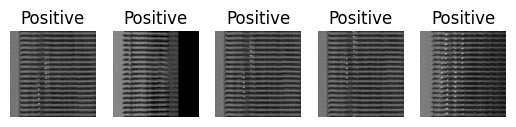

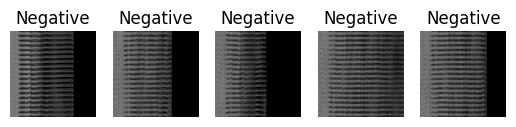

In [ ]:



import matplotlib.pyplot as plt
from PIL import Image
import os

# Assuming images are stored in two folders: 'positive' and 'negative'
positive_images_dir = '/content/drive/MyDrive/dataset/Training_images/Training_images/Positive'
negative_images_dir = '/content/drive/MyDrive/dataset/Training_images/Training_images/Negative'

# Function to display images
def display_images(images_dir, title):
    image_files = os.listdir(images_dir)

    # Display the first 5 images
    for i, image_file in enumerate(image_files[:5]):
        img = Image.open(os.path.join(images_dir, image_file))
        plt.subplot(1, 5, i+1)
        plt.title(title)
        plt.imshow(img)
        plt.axis('off')
    plt.show()

# Display positive and negative images
display_images(positive_images_dir, 'Positive')
display_images(negative_images_dir, 'Negative')

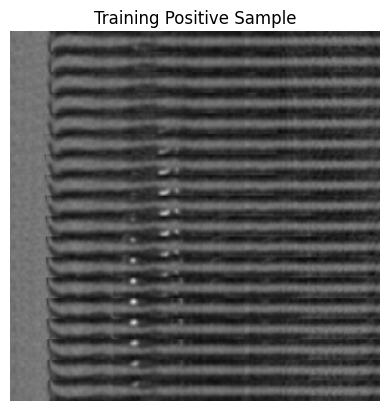

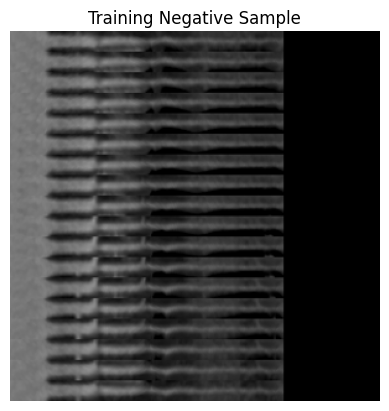

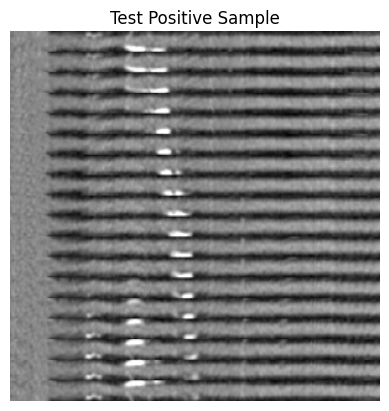

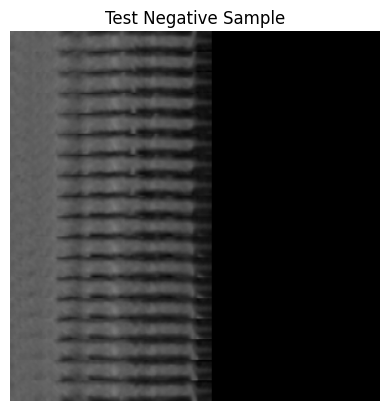

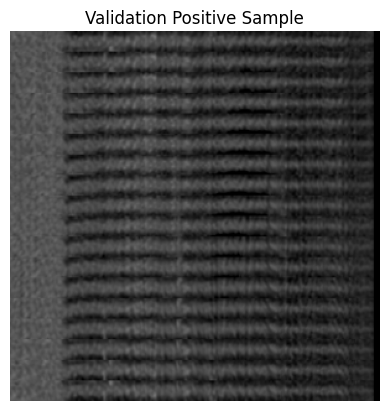

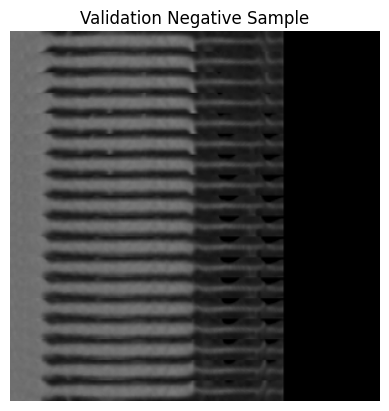

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tensorflow.keras.models import load_model

# Load the best models
best_model_resnet50 = load_model('/content/drive/MyDrive/heart artery/Copy of bestmodel_resnet50.hdf5')
best_model_densenet121 = load_model('/content/drive/MyDrive/heart artery/Copy of bestmodel_densnet121.hdf5')
best_model_vgg16 = load_model('/content/drive/MyDrive/heart artery/Copy of bestmodel_vgg16.hdf5')
best_model_vgg19 = load_model('/content/drive/MyDrive/heart artery/Copy of bestmodel_vgg19.hdf5')
best_model_densenet201 = load_model('/content/drive/MyDrive/heart artery/Copy of bestmodel_densenet201.hdf5')
best_model_googlenet = load_model('/content/drive/MyDrive/heart artery/Copy of bestmodel_googlenet.hdf5')

# Define a function for evaluation
def evaluate_model(model, generator):
    # Predict classes
    y_pred = model.predict(generator)
    y_pred_classes = np.round(y_pred).flatten()

    # True classes
    y_true = generator.classes

    # Calculate accuracy
    accuracy = accuracy_score(y_true, y_pred_classes)
    print("Accuracy:", accuracy)

    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred_classes)
    print("Confusion Matrix:")
    print(cm)

    # Calculate sensitivity and specificity
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    print("Sensitivity (True Positive Rate):", sensitivity)
    print("Specificity (True Negative Rate):", specificity)

    # Calculate precision, recall, and F1-score
    report = classification_report(y_true, y_pred_classes)
    print("Classification Report:")
    print(report)

# # Evaluate ResNet50 model
# print("Evaluation for ResNet50:")
# evaluate_model(best_model_resnet50, validation_generator)

# Evaluate DenseNet121 model
print("Evaluation for DenseNet121:")
evaluate_model(best_model_densenet121, validation_generator)

# Evaluate VGG16 model
print("Evaluation for VGG16:")
evaluate_model(best_model_vgg16, validation_generator)

# Evaluate VGG19 model
print("Evaluation for VGG19:")
evaluate_model(best_model_vgg19, validation_generator)

# Evaluate DenseNet201 model
print("Evaluation for DenseNet201:")
evaluate_model(best_model_densenet201, validation_generator)

# Evaluate GoogLeNet model
print("Evaluation for GoogLeNet:")
evaluate_model(best_model_googlenet, validation_generator)


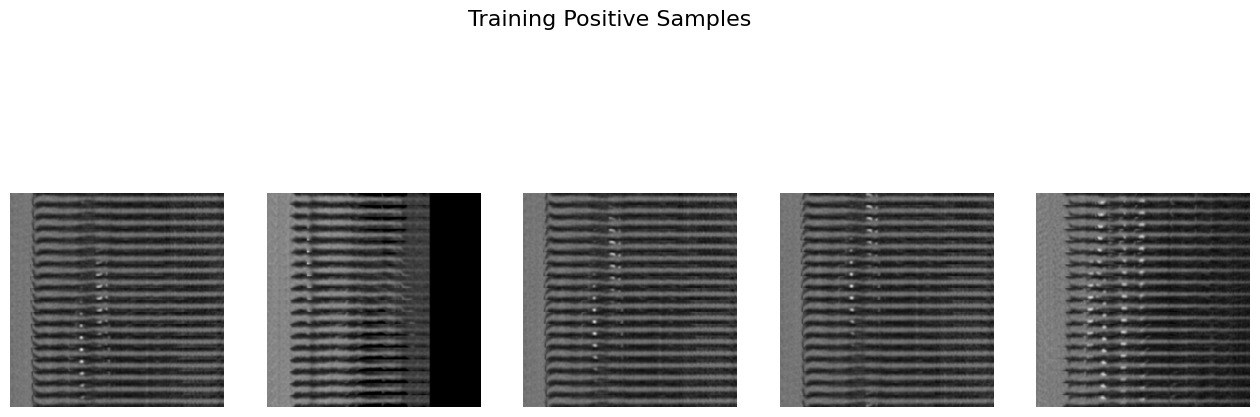

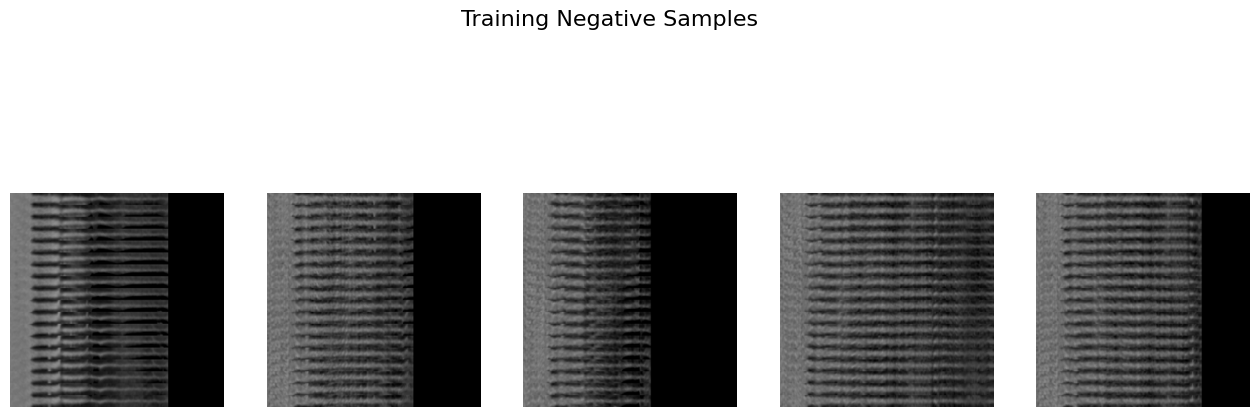

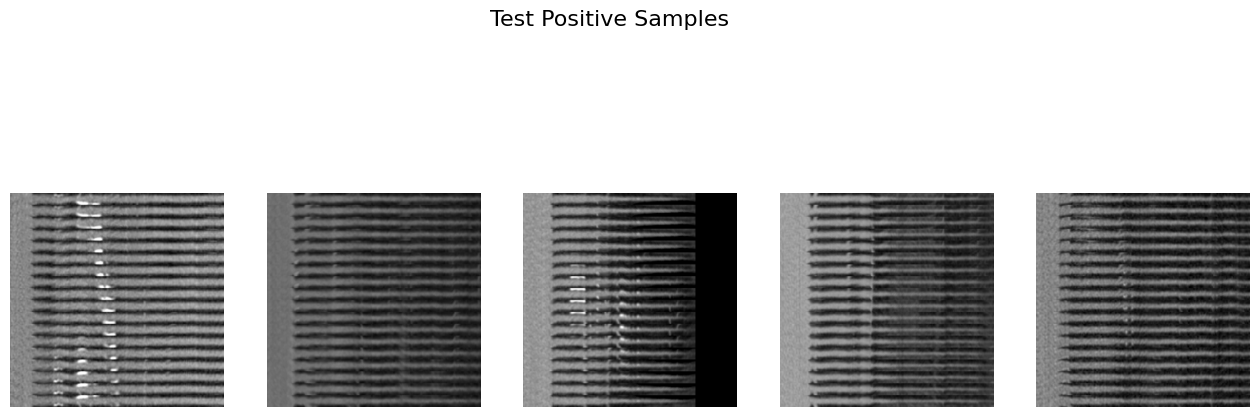

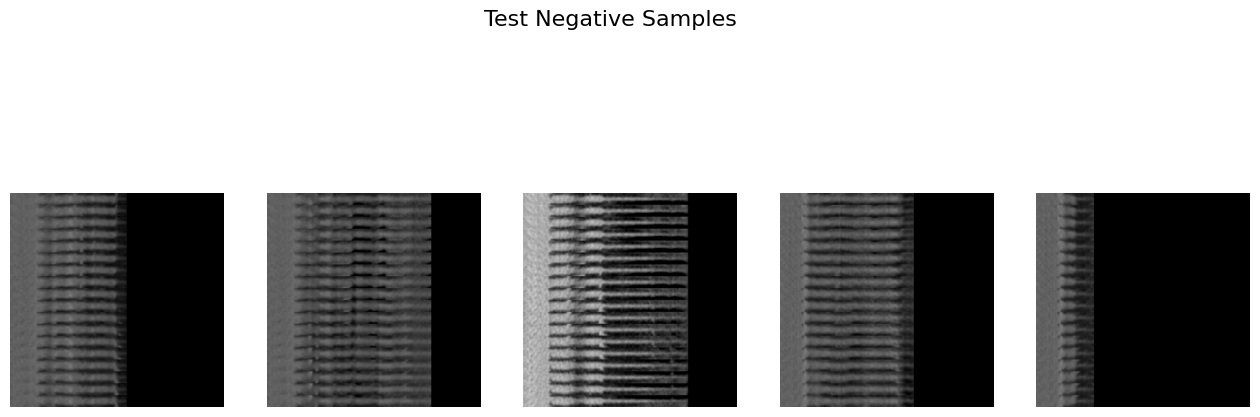

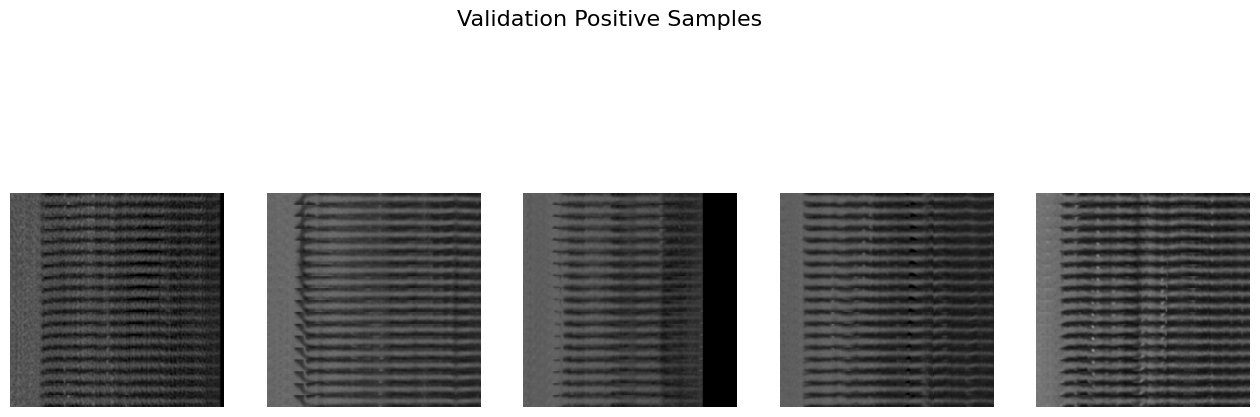

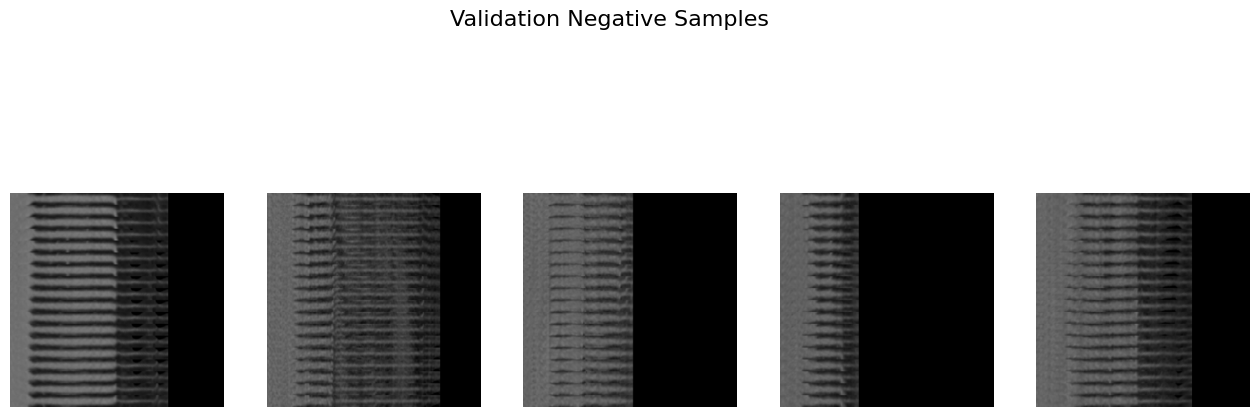

In [ ]:
import os
import matplotlib.pyplot as plt
import cv2

# Define the paths to your dataset directories
train_positive_dir = "/content/drive/MyDrive/dataset/Training_images/Training_images/Positive"
train_negative_dir = "/content/drive/MyDrive/dataset/Training_images/Training_images/Negative"
test_positive_dir = "/content/drive/MyDrive/dataset/Test_images/Test_images/Positive"
test_negative_dir = "/content/drive/MyDrive/dataset/Test_images/Test_images/Negative"
validation_positive_dir = "/content/drive/MyDrive/dataset/Validation_images/Validation_images/Positive"
validation_negative_dir = "/content/drive/MyDrive/dataset/Validation_images/Validation_images/Negative"

# Function to load and plot example images horizontally
def plot_example_images_horizontal(image_dir, title):
    # Get the list of image filenames in the directory
    image_files = os.listdir(image_dir)
    # Load and plot example images horizontally
    plt.figure(figsize=(16, 6))
    for i in range(5):
        img = cv2.imread(os.path.join(image_dir, image_files[i]))
        plt.subplot(1, 5, i+1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
    plt.suptitle(title, fontsize=16)
    plt.show()

# Plot example images horizontally for each subset in your dataset
plot_example_images_horizontal(train_positive_dir, 'Training Positive Samples')
plot_example_images_horizontal(train_negative_dir, 'Training Negative Samples')
plot_example_images_horizontal(test_positive_dir, 'Test Positive Samples')
plot_example_images_horizontal(test_negative_dir, 'Test Negative Samples')
plot_example_images_horizontal(validation_positive_dir, 'Validation Positive Samples')
plot_example_images_horizontal(validation_negative_dir, 'Validation Negative Samples')


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
def load_data(train_data_folder, validation_data_folder, img_rows, img_cols, color_type=3):
    train_datagen = ImageDataGenerator(rescale=1./255)
    valid_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        train_data_folder,
        target_size=(img_rows, img_cols),
        color_mode='rgb',
        batch_size=32,
        class_mode='binary')

    validation_generator = valid_datagen.flow_from_directory(
        validation_data_folder,
        target_size=(img_rows, img_cols),
        color_mode='rgb',
        batch_size=32,
        class_mode='binary')

    return train_generator, validation_generator

train_data_folder = "/content/drive/MyDrive/heart artery/Training_images/Training_images"
validation_data_folder = "/content/drive/MyDrive/heart artery/Validation_images/Validation_images"
img_rows, img_cols = 128, 128

train_generator, validation_generator = load_data(train_data_folder, validation_data_folder, img_rows, img_cols)


best_model_resnet50 = load_model('/content/drive/MyDrive/heart artery/bestmodel_resnet50.hdf5')
best_model_densenet121 = load_model('/content/drive/MyDrive/heart artery/bestmodel_densnet121.hdf5')
best_model_vgg16 = load_model('/content/drive/MyDrive/heart artery/bestmodel_vgg16.hdf5')
best_model_vgg19 = load_model('/content/drive/MyDrive/heart artery/bestmodel_vgg19.hdf5')
best_model_densenet201 = load_model('/content/drive/MyDrive/heart artery/bestmodel_densenet201.hdf5')
best_model_googlenet = load_model('/content/drive/MyDrive/heart artery/bestmodel_googlenet.hdf5')

# Define a function for evaluation
def evaluate_model(model, generator):
    # Predict classes
    y_pred = model.predict(generator)
    y_pred_classes = np.round(y_pred).flatten()

    # True classes
    y_true = generator.classes

    # Calculate accuracy
    accuracy = accuracy_score(y_true, y_pred_classes)
    print("Accuracy:", accuracy)

    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred_classes)
    print("Confusion Matrix:")
    print(cm)

    # Calculate sensitivity and specificity
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    print("Sensitivity (True Positive Rate):", sensitivity)
    print("Specificity (True Negative Rate):", specificity)

    # Calculate precision, recall, and F1-score
    report = classification_report(y_true, y_pred_classes)
    print("Classification Report:")
    print(report)

# # Evaluate ResNet50 model
# print("Evaluation for ResNet50:")
# evaluate_model(best_model_resnet50, validation_generator)

# Evaluate DenseNet121 model
print("Evaluation for DenseNet121:")
evaluate_model(best_model_densenet121, validation_generator)

# Evaluate VGG16 model
print("Evaluation for VGG16:")
evaluate_model(best_model_vgg16, validation_generator)

# Evaluate VGG19 model
print("Evaluation for VGG19:")
evaluate_model(best_model_vgg19, validation_generator)

# Evaluate DenseNet201 model
print("Evaluation for DenseNet201:")
evaluate_model(best_model_densenet201, validation_generator)

# Evaluate GoogLeNet model
print("Evaluation for GoogLeNet:")
evaluate_model(best_model_googlenet, validation_generator)


Found 4668 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Evaluation for DenseNet121:
4/4 [==============================] - 52s 16s/step
Accuracy: 0.48
Confusion Matrix:
[[31 19]
 [33 17]]
Sensitivity (True Positive Rate): 0.34
Specificity (True Negative Rate): 0.62
Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.62      0.54        50
           1       0.47      0.34      0.40        50

    accuracy                           0.48       100
   macro avg       0.48      0.48      0.47       100
weighted avg       0.48      0.48      0.47       100

Evaluation for VGG16:
4/4 [==============================] - 9s 1s/step
Accuracy: 0.57
Confusion Matrix:
[[27 23]
 [20 30]]
Sensitivity (True Positive Rate): 0.6
Specificity (True Negative Rate): 0.54
Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.54      0.56        50
           1       0.57 

Found 4668 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
ResNet expected input shape: (None, 128, 128, 3)
Validation data shape: (32, 128, 128, 3)
4/4 [==============================] - 2s 134ms/step - loss: 8.9968 - accuracy: 0.5000
ResNet: Validation Loss: 8.9968, Validation Accuracy: 0.5000
Googlenet expected input shape: (None, 128, 128, 3)
Validation data shape: (32, 128, 128, 3)
4/4 [==============================] - 2s 134ms/step - loss: 121.8599 - accuracy: 0.5000
Googlenet: Validation Loss: 121.8599, Validation Accuracy: 0.5000
Densenet201 expected input shape: (None, 128, 128, 3)
Validation data shape: (32, 128, 128, 3)
4/4 [==============================] - 5s 156ms/step - loss: 24.1042 - accuracy: 0.5000
Densenet201: Validation Loss: 24.1042, Validation Accuracy: 0.5000
Vgg16 expected input shape: (None, 128, 128, 3)
Validation data shape: (4, 128, 128, 3)
4/4 [==============================] - 2s 136ms/step - loss: 13.0360 - accuracy: 0.5000
Vgg16

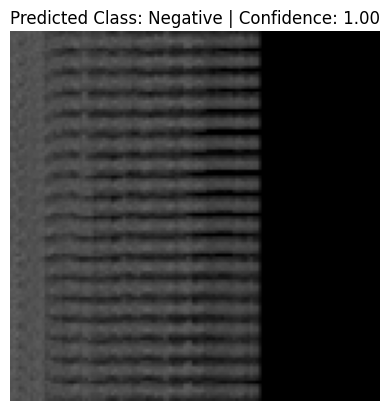

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
import tensorflow as tf


image_height, image_width = 128, 128
num_classes = 4  # Make sure this matches the actual number of classes
batch_size = 32
epochs = 10
train_data_dir = '/content/drive/MyDrive/heart artery/Training_images/Training_images'
val_data_dir = '/content/drive/MyDrive/heart artery/Validation_images/Validation_images'

# Data generators for training and validation
train_datagen = image.ImageDataGenerator(preprocessing_function=preprocess_input,
                                         rotation_range=20,
                                         width_shift_range=0.2,
                                         height_shift_range=0.2,
                                         shear_range=0.2,
                                         zoom_range=0.2,
                                         horizontal_flip=True)

val_datagen = image.ImageDataGenerator(preprocessing_function=preprocess_input)

# Training data generator
train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                    target_size=(image_height, image_width),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

# Validation data generator
val_generator = val_datagen.flow_from_directory(val_data_dir,
                                                target_size=(image_height, image_width),
                                                batch_size=batch_size,
                                                class_mode='categorical')

# Load the trained models
models = {
    'ResNet': tf.keras.models.load_model('/content/drive/MyDrive/heart artery/bestmodel_resnet50.hdf5'),
    'Googlenet': tf.keras.models.load_model('/content/drive/MyDrive/heart artery/bestmodel_googlenet.hdf5'),
    'Densenet201': tf.keras.models.load_model('/content/drive/MyDrive/heart artery/bestmodel_densenet201.hdf5'),
    'Vgg16': tf.keras.models.load_model('/content/drive/MyDrive/heart artery/bestmodel_vgg16.hdf5'),
    'DenseNet121': tf.keras.models.load_model('/content/drive/MyDrive/heart artery/bestmodel_densnet121.hdf5'),
    'Vgg19': tf.keras.models.load_model('/content/drive/MyDrive/heart artery/bestmodel_vgg19.hdf5')
}

# Evaluate the models on the validation data
for model_name, model in models.items():
    # Check the input shape of the model
    print(f"{model_name} expected input shape: {model.input_shape}")

    # Check the shape of the validation data
    images, labels = next(val_generator)
    print(f"Validation data shape: {images.shape}")

    # If the shapes match, evaluate the model on the validation data
    if images.shape[1:] == model.input_shape[1:]:
        val_loss, val_accuracy = model.evaluate(val_generator)
        print(f'{model_name}: Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')
    else:
        print(f"The validation data shape does not match the {model_name}'s expected input shape.")

# Path to the image you want to predict
image_path = '/content/drive/MyDrive/heart artery/Training_images/Training_images/Negative/Negative_100_Coronary_007_RCA_Secondary1_11.png'

# Preprocess the input image
img = image.load_img(image_path, target_size=(image_height, image_width))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Make prediction with one of the models (e.g., ResNet)
model_name = 'ResNet'
model = models[model_name]
prediction = model.predict(img_array)

# Interpret the prediction results
class_names = train_generator.class_indices
predicted_class_index = np.argmax(prediction)
predicted_class = list(class_names.keys())[predicted_class_index]
confidence_score = prediction[0][predicted_class_index]

# Show the image with predicted class and confidence score
plt.imshow(img)
plt.axis('off')
plt.title(f'Predicted Class: {predicted_class} | Confidence: {confidence_score:.2f}')
plt.show()
